In [1]:
from pandas_datareader import data

In [2]:
tickers=["^GSPC"]
start_date="1991-12-31"
end_date="2022-01-01"

panel_data= data.DataReader("^GSPC", "yahoo", start_date, end_date)

In [39]:
snp = panel_data.reset_index()[["Date", "Adj Close"]]

In [40]:
import numpy as np
snp["logPX"] = np.log(snp["Adj Close"])

In [41]:
snp["log_rtn"] = snp["logPX"].pct_change()

In [8]:
import matplotlib.pyplot as plt

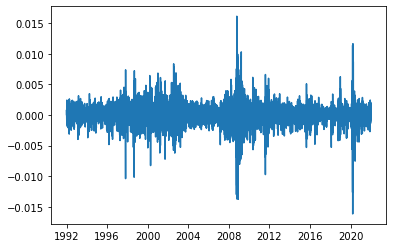

In [9]:
plt.plot(snp["Date"], snp["log_rtn"])

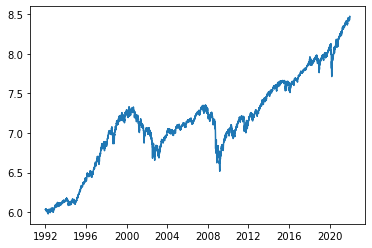

In [10]:
plt.plot(snp["Date"], snp["logPX"])

In [11]:
import pandas as pd
vol = pd.read_csv("""C:\\Users\\Young Jin Park\\git\\MTDS\\oxfordmanrealizedvolatilityindices.csv""")

In [27]:
vol.columns

Index(['Unnamed: 0', 'Symbol', 'bv_ss', 'rv10_ss', 'rk_twoscale', 'rsv',
       'close_time', 'open_to_close', 'open_price', 'open_time', 'rk_th2',
       'rv5', 'close_price', 'medrv', 'nobs', 'rsv_ss', 'bv', 'rv5_ss', 'rv10',
       'rk_parzen'],
      dtype='object')

In [28]:
snpVol = vol.query("""Symbol=='.SPX'""")[["Unnamed: 0", "rv5_ss"]]

In [29]:
snpVol.columns=["DATE", "RV5"]

In [30]:
snpVol.DATE = pd.to_datetime(snpVol.DATE.apply(lambda x : str(x)[:10]))

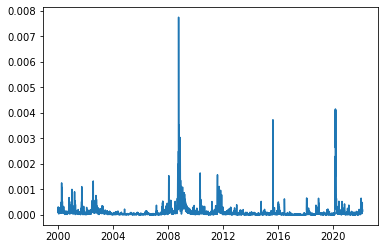

In [32]:
plt.plot(snpVol.DATE, snpVol.RV5)

In [33]:
snpVol.DATE

131983   2000-01-03
131984   2000-01-04
131985   2000-01-05
131986   2000-01-06
131987   2000-01-07
            ...    
137534   2022-02-25
137535   2022-02-28
137536   2022-03-01
137537   2022-03-02
137538   2022-03-03
Name: DATE, Length: 5556, dtype: datetime64[ns]

In [37]:
snp.Date

Series([], Name: Date, dtype: datetime64[ns])

In [43]:
dates = sorted(list(set(pd.to_datetime(snp.Date)).intersection(set(snpVol.DATE))))

In [44]:
dates

[Timestamp('2000-01-03 00:00:00'),
 Timestamp('2000-01-04 00:00:00'),
 Timestamp('2000-01-05 00:00:00'),
 Timestamp('2000-01-06 00:00:00'),
 Timestamp('2000-01-07 00:00:00'),
 Timestamp('2000-01-10 00:00:00'),
 Timestamp('2000-01-11 00:00:00'),
 Timestamp('2000-01-12 00:00:00'),
 Timestamp('2000-01-13 00:00:00'),
 Timestamp('2000-01-14 00:00:00'),
 Timestamp('2000-01-18 00:00:00'),
 Timestamp('2000-01-19 00:00:00'),
 Timestamp('2000-01-20 00:00:00'),
 Timestamp('2000-01-21 00:00:00'),
 Timestamp('2000-01-24 00:00:00'),
 Timestamp('2000-01-25 00:00:00'),
 Timestamp('2000-01-26 00:00:00'),
 Timestamp('2000-01-27 00:00:00'),
 Timestamp('2000-01-28 00:00:00'),
 Timestamp('2000-01-31 00:00:00'),
 Timestamp('2000-02-01 00:00:00'),
 Timestamp('2000-02-02 00:00:00'),
 Timestamp('2000-02-03 00:00:00'),
 Timestamp('2000-02-04 00:00:00'),
 Timestamp('2000-02-07 00:00:00'),
 Timestamp('2000-02-08 00:00:00'),
 Timestamp('2000-02-09 00:00:00'),
 Timestamp('2000-02-10 00:00:00'),
 Timestamp('2000-02-

In [45]:
snp = snp[snp.Date.isin(dates)]
snpVol = snpVol[snpVol.DATE.isin(dates)]

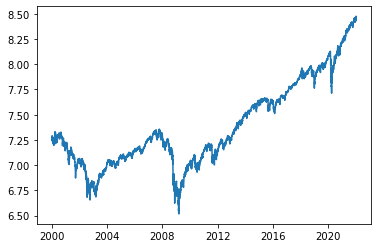

In [46]:
plt.plot(snp.Date, snp.logPX)

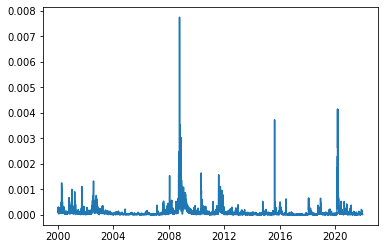

In [47]:
plt.plot(snpVol.DATE, snpVol.RV5)

### HMM Learn

In [48]:
from hmmlearn.hmm import GaussianHMM

In [216]:
snpVol = snpVol.rename(columns={"DATE" : "Date"})

In [217]:
full_X = snp.merge(snpVol, how="inner", on="Date")

In [332]:
full_X["R_mean"] = full_X.log_rtn.rolling(5).mean()
full_X["Abs_5day"] = np.abs(full_X.log_rtn.diff(periods=5))

In [331]:
full_X

,Date,Adj Close,logPX,log_rtn,RV5,R_mean,Abs_5day
0,2000-01-03,1455.219971,7.282912,-0.763574,0.542620,NaN,NaN
1,2000-01-04,1399.420044,7.243813,-3.115630,0.863674,NaN,NaN
2,2000-01-05,1402.109985,7.245734,0.153849,1.211064,NaN,NaN
3,2000-01-06,1403.449951,7.246689,0.076508,0.504066,NaN,NaN
4,2000-01-07,1441.469971,7.273419,2.140631,0.360765,-0.301643,NaN
...,...,...,...,...,...,...,...
5510,2021-12-27,4791.189941,8.474534,0.942730,0.068939,0.498116,1.653056
5511,2021-12-28,4786.350098,8.473523,-0.069211,0.116867,0.641815,0.718494
5512,2021-12-29,4793.060059,8.474924,0.095947,0.070336,0.418288,1.117632
5513,2021-12-30,4778.729980,8.471930,-0.205037,0.056785,0.238063,0.901129


In [333]:
for col in ["log_rtn", "R_mean", "RV5", "Abs_5day"]:
    full_X[col] = full_X[col] / np.std(full_X[col])
    

In [334]:
train_X = full_X[full_X["Date"] <= pd.Timestamp("2009-12-31")].dropna()
test_X = full_X[full_X["Date"] > pd.Timestamp("2009-12-31")]

In [335]:
train_dates = train_X.Date
test_dates = test_X.Date

train_data = np.column_stack([train_X.log_rtn, train_X.R_mean, train_X.RV5, train_X.Abs_5day])
test_data = np.column_stack([test_X.log_rtn, test_X.R_mean, test_X.RV5, test_X.Abs_5day])

#### HMM 

In [339]:
model = GaussianHMM(n_components=2, covariance_type="full", n_iter=10).fit(train_data)

In [340]:
hidden_states=model.predict(test_data)

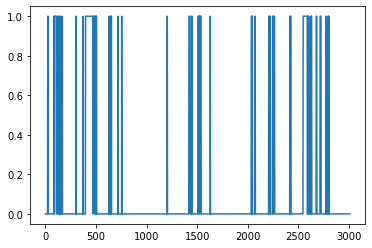

In [341]:
plt.plot(hidden_states)

#### Jump model

In [348]:
jumped = sparse_jump(test_data, 2, 2, jump_penalty=1e-1)

In [349]:
jumped

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0.19707507, 0.93935021, 0.22353252, 0.16975221]))

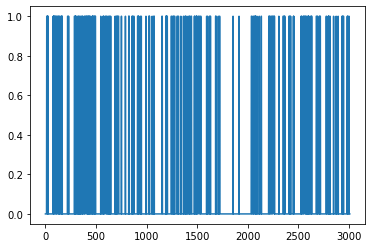

In [350]:
plt.plot(jumped[0])

In [316]:
import numpy as np
from scipy.spatial.distance import cdist


def sparse_jump(Y, n_states, max_features, jump_penalty=1e-5,
                max_iter=10, tol=1e-4, n_init=10, verbose=False):
    # Implementation of sparse jump model
    n_obs, n_features = Y.shape
    max_features = np.clip(max_features, a_min=1, a_max=np.sqrt(n_features))
    feat_w = np.repeat(1 / np.sqrt(n_features), n_features)
    states = None

    for it in range(max_iter):
        states = jump(Y * np.sqrt(feat_w),
                      n_states,
                      initial_states=states,
                      jump_penalty=jump_penalty,
                      n_init=n_init)
        if len(np.unique(states)) == 1:
            break
        else:
            new_w = get_weights(Y, states, max_features, n_states)
        if abs(new_w - feat_w).sum() / abs(feat_w).sum() < tol:
            break
        elif verbose:
            print('Iteration {}, w diff {:.6e}'.format(it, abs(new_w - feat_w).sum()))
        feat_w = new_w

    return states, feat_w


def jump(Y, n_states, jump_penalty=1e-5, initial_states=None,
         max_iter=10, n_init=10, tol=None, verbose=False):
    # Fit jump model using framework of Bemporad et al. (2018)
    if initial_states is not None:
        initial_states = np.array(initial_states, dtype=np.int64)
        if len(np.unique(initial_states)) == n_states:
            s = initial_states.copy()
        else:
            s = init_states(Y, n_states)
    else:
        s = init_states(Y, n_states)

    n_obs, n_features = Y.shape
    Gamma = jump_penalty * (1 - np.eye(n_states)) 
    best_loss = None
    best_s = None

    for init in range(n_init):
        mu = np.zeros((n_states, n_features))
        loss_old = 1e10
        for it in range(max_iter):
            # Fit model by updating mean of observed states
            for i in np.unique(s):
                mu[i] = np.mean(Y[s==i], axis=0)
            # Fit state sequence
            s_old = s.copy()
            loss_by_state = cdist(mu, Y, 'euclidean').T**2
            V = loss_by_state.copy()
            for t in range(n_obs-1, 0, -1):
                V[t-1] = loss_by_state[t-1] + (V[t] + Gamma).min(axis=1)
            s[0] = V[0].argmin()
            for t in range(1, n_obs):
                s[t] = (Gamma[s[t-1]] + V[t]).argmin()
            # Monitor convergence
            if len(np.unique(s)) == 1:
                break
            loss = min(V[0])
            if verbose:
                print('Iteration {}: {:.6e}'.format(it, loss))
            if tol:
                epsilon = loss_old - loss 
                if epsilon < tol:
                    break
            elif np.array_equal(s, s_old):
                break
            loss_old = loss
            
        if (best_s is None) or (loss_old < best_loss):
            best_loss = loss_old
            best_s = s.copy()
        s = init_states(Y, n_states)

    return best_s


def init_states(Y, n_states):
    # Generate initial states using K-means++ (Arthur and Vassilvitskii, 2007) 
    n_obs, n_features = Y.shape
    centers = np.zeros((n_states, n_features))
    center_idx = np.random.randint(n_obs)
    centers[0] = Y[center_idx]
    n_local_trials = 2 + int(np.log(n_states))
    closest_dist_sq = cdist(centers[0, None], Y, 'euclidean')**2
    current_pot = closest_dist_sq.sum()
    
    for i in range(1, n_states):
        rand_vals = np.random.sample(n_local_trials) * current_pot
        candidate_ids = np.searchsorted(np.cumsum(closest_dist_sq), 
                                        rand_vals)
        distance_to_candidates = cdist(Y[candidate_ids], Y, 'euclidean')**2
        # Decide which candidate is the best
        best_candidate = None
        best_pot = None
        best_dist_sq = None
        for trial in range(n_local_trials):
            # Compute potential when including center candidate
            new_dist_sq = np.minimum(closest_dist_sq,
                                     distance_to_candidates[trial])
            new_pot = new_dist_sq.sum()

            # Store result if it is the best local trial so far
            if (best_candidate is None) or (new_pot < best_pot):
                best_candidate = candidate_ids[trial]
                best_pot = new_pot
                best_dist_sq = new_dist_sq

        centers[i] = Y[best_candidate]
        current_pot = best_pot
        closest_dist_sq = best_dist_sq
    
    # Compute the state assignment
    states = cdist(centers, Y, 'euclidean').argmin(axis=0)
        
    return states


def get_weights(Y, states, max_features, n_states):
    # Find weights given a state sequence by maximizing the interstate distance
    BCSS = get_BCSS(Y, states)
    delta = binary_search(BCSS, max_features)
    w = calc_new_feature_weights(BCSS, delta)

    return w


def get_BCSS(Y, states):
    # Find BCSS given a state sequence
    WCSS = np.zeros(Y.shape[1])
    for i in np.unique(states):
        mask = (states == i)
        if mask.sum() > 1:
            WCSS += np.square(Y[mask] - np.mean(Y[mask], axis=0)).sum(axis=0)
    TSS = np.square(Y - np.mean(Y, axis=0)).sum(axis=0)

    return TSS - WCSS


def binary_search(objective, norm_constraint, max_iter=15):
    l2n_arg = np.linalg.norm(objective)
    if l2n_arg == 0 or abs(objective / l2n_arg).sum() <= norm_constraint:
        return 0
    lam1 = 0
    lam2 = abs(objective).max() - 1e-5
    for iter in range(max_iter):
        su = soft_threshold(objective, (lam1 + lam2) / 2)
        if abs(su / np.linalg.norm(su)).sum() < norm_constraint:
            lam2 = (lam1 + lam2) / 2
        else:
            lam1 = (lam1 + lam2) / 2
        if (lam2 - lam1) < 1e-4:
            break

    return (lam1 + lam2) / 2


def calc_new_feature_weights(objective, delta):
    # Calculate feature weights using soft thresholding
    soft = soft_threshold(objective, delta)
    w = soft / np.linalg.norm(soft)
    
    return w


def soft_threshold(x, delta):
    
    return np.sign(x) * np.maximum(0, np.abs(x) - delta)
